In [1]:
# Imports
import random
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model

import torch

import keijzer_exogan as ke

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks')


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 1000 #25*10**3 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%

lr = 1e-1
lamb1 = 1 #1e4
lamb2 = 10 # 1 , total_loss = lamb1*loss_context + lamb2*loss_perceptual

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [2] # Number of GPUs available. Use 0 for CPU mode.

#n_images = 500
inpaint_n_times = 1

save_array_results = True
load_array_results = False
filename = 'debug'

In [2]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...

# Load all ASPAs

# Load smaller selection of ASPAs

In [3]:
images = np.load(path+'last_chunks_25_percent_images_v4.1.npy') # 4.1 is a random selection of 5k images
print('Loaded %s images' % len(images))

print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = False

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[0:5000] # 200 should take ~ 11 hours
n_images = len(images)
#images = images[:int(len(images)*0.005)]
print('Number of images: ', n_images)

dataset = ke.numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

Loaded 5000 images
Batch size:  1
Number of GPUs used:  1
Number of images:  5000


In [4]:
"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('gan_data//weights//netG_state_dict0_v4_test', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('gan_data//weights//netD_state_dict0_v4_test', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()





"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, device_ids=selected_gpus, output_device=device)
    D = nn.DataParallel(D, device_ids=selected_gpus, output_device=device)
    #z = nn.DataParallel(z, device_ids=selected_gpus, output_device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show generated images

(tensor(-0.8555), tensor(1.1621), tensor(0.1906), tensor(0.4510))

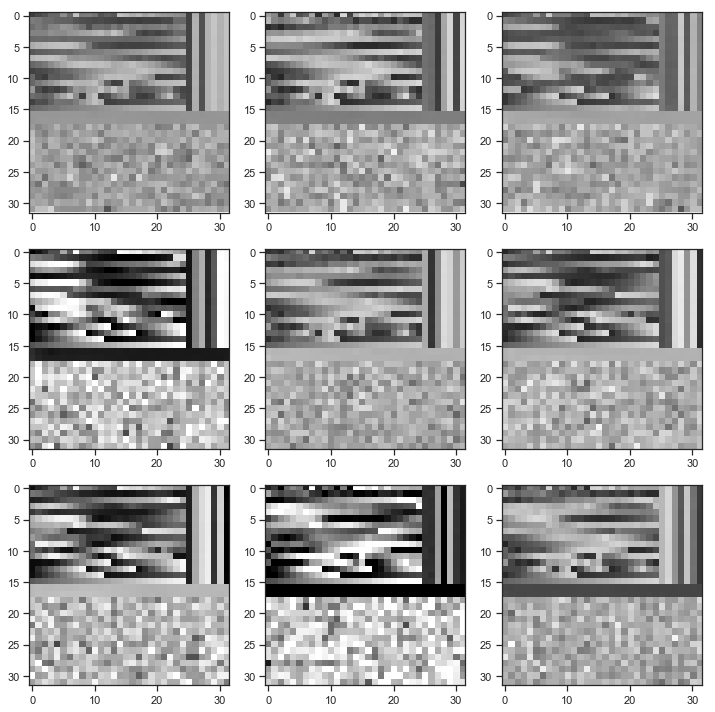

In [ ]:
from sklearn.preprocessing import MinMaxScaler

z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    img = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    #scaler = MinMaxScaler((0, 1.2))
    #img = scaler.fit_transform(img)
    plt.imshow(img, cmap='gray', vmin=-1.2, vmax=1.2)
    #plt.imshow(img, cmap='gray')

plt.tight_layout()

img.min(), img.max(), img.mean(), img.std()

# Show first 9 selected images

(-1.0, 1.0, 0.04458997574677878, 0.682812252510717)

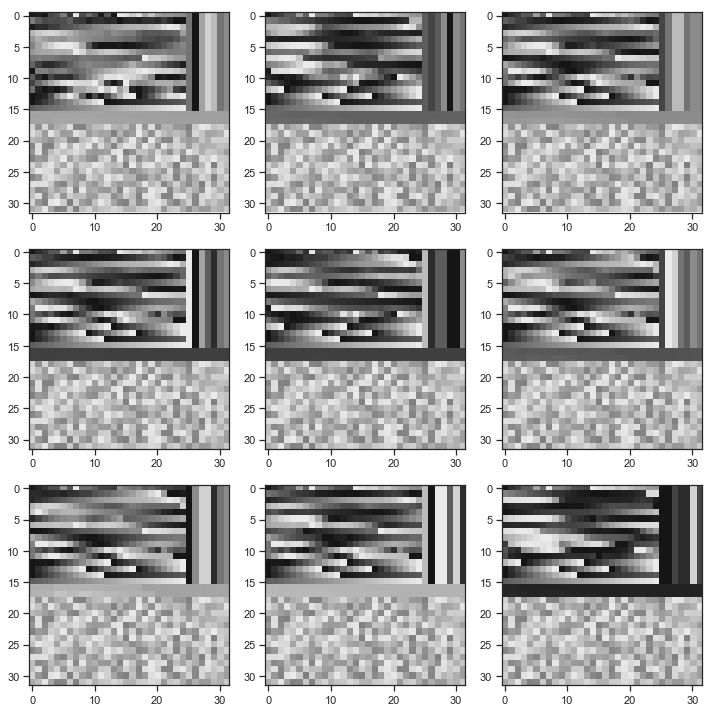

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    try:
        img = images[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img[0, :, :], cmap='gray', vmin=-1.2, vmax=1.2)
    except:
        pass

plt.tight_layout()

img.min(), img.max(), img.mean(), img.std()

# Visualizing the weights

Layer: 0 	 n_weights: 512 	 std: 0.0237 	 mean: 0.0001
Layer: 1 	 n_weights: 16384 	 std: 0.5268 	 mean: -0.0104
Layer: 2 	 n_weights: 32768 	 std: 0.8428 	 mean: 0.0680
Layer: 3 	 n_weights: 131072 	 std: 1.2882 	 mean: 0.0326
Layer: 4 	 n_weights: 524288 	 std: 0.3700 	 mean: 0.0094
Layer: 5 	 n_weights: 256 	 std: 0.0022 	 mean: -0.0004


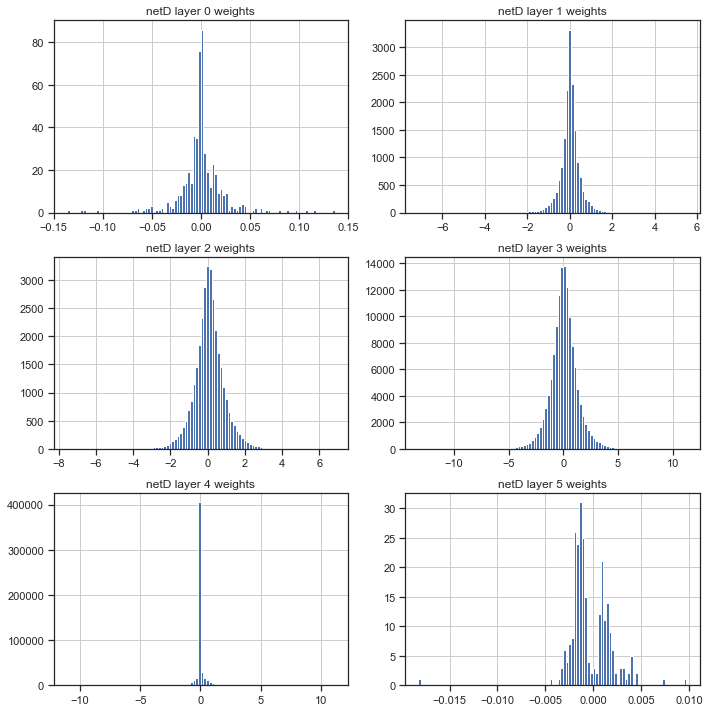

In [ ]:
weights = [param.data.cpu().numpy().flatten() for param in netD.parameters()]

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netD layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

Layer: 0 	 n_weights: 409600 	 std: 0.1779 	 mean: 0.0008
Layer: 1 	 n_weights: 524288 	 std: 0.1825 	 mean: -0.0104
Layer: 2 	 n_weights: 131072 	 std: 0.1902 	 mean: -0.0069
Layer: 3 	 n_weights: 32768 	 std: 0.1304 	 mean: -0.0135
Layer: 4 	 n_weights: 16384 	 std: 0.1025 	 mean: -0.0023
Layer: 5 	 n_weights: 512 	 std: 0.0208 	 mean: -0.0003


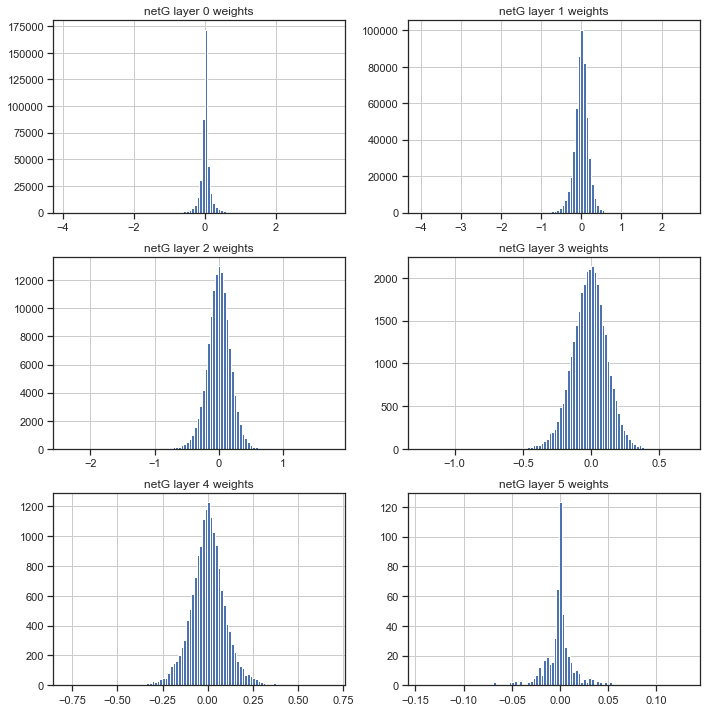

In [ ]:
weights = [param.data.cpu().numpy().flatten() for param in netG.parameters()] # where param.data are the weights of the i-th layer

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netG layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

## Create the mask

In [ ]:
def create_mask():
    
    mask = np.full([1,1,32,32], 1) # init array with 0.5's
    mask = torch.from_numpy(mask).to(device)
    
    #mask = torch.ones([1, 1, 32, 32]).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    
    # set all params to 0
    mask[:, :, :16, 25:] = 0
    
    # set noise to 0
    mask[:, :, 18:, :] = 0
    
    
    """Weighted mask"""
    # Normalization factors
    mask[:, :, 16:18, :] = 6  #6
    
    # Planet mass
    mask[:, :, :16, 25:26] = 0
    
    mask = mask.float() # make sure dtype is float, torch was complaining during inpainting that this is a double
    
    return mask

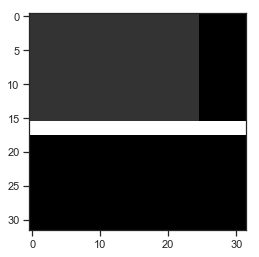

In [ ]:
m = create_mask().cpu()[0, 0, :, :]
plt.imshow(m, cmap='gray', vmin=0, vmax=5) 

# Inpaiting functions

In [ ]:
def save_inpainting_results():
    # save real aspa's
    all_reals = []
    for selected_aspa in range(len(real_images)):
        reals = np.array([real_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)])
        all_reals.append(reals)
        
    all_reals = np.array(all_reals)
    
    np.save('gan_data//val_errors//'+filename+'_reals.npy', all_reals)
    
    # save inpained aspa's
    all_inpainteds = []
    for selected_aspa in range(len(real_images)):
        inpainteds = np.array([final_inpainted_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)])
        all_inpainteds.append(inpainteds)

    all_inpainteds = np.array(all_inpainteds)
    
    np.save('gan_data//val_errors//'+filename+'_inpainteds.npy', all_inpainteds)
    
    np.save('gan_data//val_errors//'+filename+'_n_iterations.npy', n_iteration)
    np.save('gan_data//val_errors//'+filename+'_contextual_losses.npy', contextual_losses)
    np.save('gan_data//val_errors//'+filename+'_perceptual_losses.npy', perceptual_losses)
    return

## Inpainting loop
22.33 iters / s 

In [ ]:
# Lists to keep track of progress
real_images = []
masked_images= []
#inpainted_images = []
final_inpainted_images = [] # last n inpainted images, one index location for each input image [[aspa1, aspa1, aspa1], [aspa2,aspa2,aspa2]] .... where aspa1, aspa1, aspa1 are 3 unique inpaintings

n_iteration = []
perceptual_losses = []
contextual_losses = []

MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss() # MAE
SmoothL1Loss = nn.SmoothL1Loss()

"""
Inpainting
"""
t3 = time.time()
past_s_image = 0
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_images_n_times = []
    final_inpainted_images_n_times = [] # list of (n) last inpainted image(s), for one aspa
    
    t1 = time.time()
    for j in range(inpaint_n_times): # inpaint n times per image
        z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)
        real_cpu = data.to(device)
        b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

        #print("data.shape: ", data.shape)
        image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image

        real_images_n_times.append(image)
        #print("image.shape: ", image.shape)

        """Mask the image"""
        mask = create_mask()

        masked_image = torch.mul(image, mask).to(device) #image bigodot mask
        masked_images.append(masked_image)
        #print('masked image shape', masked_image.shape)
        #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

        opt = optim.Adam([z], lr=lr)

        # what's v and m?
        v = torch.tensor(0, dtype=torch.float32, device=device)
        m = torch.tensor(0, dtype=torch.float32, device=device)


        """Start the inpainting process"""
        early_stopping_n_iters = 0
        early_stopping_min_loss = 999999999999 # set to random high number to initialize
        
        if j != 0:
            n_iteration.append(iteration)
            
        for iteration in range(n_iters):
            if z.grad is not None:
                z.grad.data.zero_()

            G.zero_grad()
            D.zero_grad()


            image_generated = G(z) # generated image G(z)
            image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
            image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image

            #if (iteration % 100 == 0):
            #    inpainted_images.append(image_generated_inpainted)

            #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

            t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

            # TODO: why does this already look real?
            #plt.imshow(t, cmap='gray') # plot the masked image 

            """Calculate losses"""
            loss_context = lamb1*torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
            #loss_context = lamb1*MSELoss(image_generated_masked,masked_image)
            #loss_context = L1Loss(image_generated_masked, masked_image)*10
            #loss_context = SmoothL1Loss(image_generated_masked, masked_image)*10

            discriminator_output = netD(image_generated_inpainted) - 0.005 # -0.005 offset so loss_perceptual doesn't become 1 when D(G(z)) == 1.000000
            #print("Discriminator output: ", discriminator_output)

            labels = torch.full((b_size,), 1, device=device)
            loss_perceptual = lamb2*torch.log(1-discriminator_output)

            #if loss_perceptual == -np.inf:
            #    #print('loss perceptual == -np.inf()')
            #    loss_perceptual = torch.tensor(-10, dtype=torch.float32, device=device)

            #print(loss_perceptual.data.cpu().numpy().flatten()[0])

            total_loss = loss_context + loss_perceptual
            #total_loss = loss_context + 10*discriminator_output

            # grab the values from losses for printing
            loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
            #loss_perceptual = 0
            loss_context = loss_context.data.cpu().numpy().flatten()[0]



            total_loss.backward()
            opt.step()

            total_loss = total_loss.data.cpu().numpy().flatten()[0]

            """Early stopping""" # TODO: 
            if iteration > 0:
                delta_loss = early_stopping_min_loss - total_loss
                delta_iters = iteration - iter1

                if (delta_loss < 0.1) or (total_loss > early_stopping_min_loss):
                    early_stopping_n_iters += 1
                else:
                    #print('set to zero')
                    early_stopping_n_iters = 0

                if early_stopping_n_iters > 4000:
                    #n_iteration.append(iteration)
                    break

            loss1 = total_loss
            iter1 = iteration

            if total_loss < early_stopping_min_loss:
                early_stopping_min_loss = total_loss
                best_inpained_image = image_generated_inpainted.detach().cpu()
                contextual_loss_best = loss_context
                perceptual_loss_best = loss_perceptual
                early_stopping_n_iters = 0
                #print('min loss: ', early_stopping_min_loss)

            t2 = time.time()

            """Calculate ETA"""
            #t_per_iter = t2 - t1 # time per iteration in seconds
            past_time = t2 - t3
            #eta = t_per_iter * (n_iters - iteration) + t_per_iter* (len(images)-i+1) * n_iters # time left to finish epoch/image + time left to finish all epochs/images in SECONDS
            #eta_h = (eta/ 60) // 60 # divisor integer
            #eta_m = eta % 60 # get remainer
            past_m = past_time / 120
            past_s = past_time % 60
            
            
            
            
            if (iteration % 50 == 0):
                print("\r image [{}/{}] inpainting [{}/{}] iteration : {:4} , context_loss: {:.3f}, perceptual_loss: {:3f}, total_loss: {:3f}, min L: {:3f}, {:1f}, D(G(z)): {:3f}, Run time: {:.0f}m {:.0f}s, s per image {:.0f}s".format(i+1, 
                len(images), j+1, inpaint_n_times, iteration, loss_context,loss_perceptual, total_loss,early_stopping_min_loss, early_stopping_n_iters, discriminator_output.data.cpu().numpy().flatten()[0], past_m, past_s, past_s_image),end="")



            """NaN monitor"""
            #if (loss_context or loss_perceptual == np.nan()) and iteration >64:
            #    print(r'='*10 + '     NaN     '+ '='*10)
            #    print(loss_context, loss_percept  ual)
                #break+

        final_inpainted_images_n_times.append(best_inpained_image.detach().cpu())
    
    past_s_image = (t2-t1) % 60
    final_inpainted_images.append(final_inpainted_images_n_times)
    real_images.append(real_images_n_times)
    contextual_losses.append(contextual_loss_best)
    perceptual_losses.append(perceptual_loss_best)
    
    if save_array_results:
        save_inpainting_results()

 image [129/5000] inpainting [1/1] iteration :  700 , context_loss: 26.603, perceptual_loss: -0.000835, total_loss: 26.602034, min L: 20.744799, 359.000000, D(G(z)): 0.565951, Run time: 5m 53s, s per image 5s

In [ ]:
perceptual_losses

# Error of one ASPA

In [ ]:
selected_aspa = 0


reals = [real_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]

inpainteds = [final_inpainted_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]

In [ ]:
reals[0].shape

In [ ]:
reals = [ke.decode_params_from_aspa(aspa_real) for aspa_real in reals]
inpainteds = [ke.decode_params_from_aspa(aspa_inpainted) for aspa_inpainted in inpainteds]

In [ ]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': [],
    'temp_profile': [],
    'ch4_mixratio': [],
    'planet_radius': [],
    'h2o_mixratio': [],
    'co2_mixratio': [],
    'co_mixratio': []
}

In [ ]:
# iterate over all params
for i,param in enumerate(inpainted_params):
    # iterate over all inpainted values (of above param)
    for j,inpainted in enumerate(inpainteds):
        y_hat = reals[j][param] # real value
        y = inpainted[param] # inpainted value
        
        percentage_error = ((y - y_hat) / y_hat)*100
        
        inpainted_params[param] += [percentage_error]

In [ ]:
df = pd.DataFrame(inpainted_params)
df = df.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf later
df.describe()

In [ ]:
df

# Error per ASPA

In [ ]:
def calculate_aspa_error(selected_aspa):
    """
    Index value of selected aspa -> final_inpainted_images[selected_aspa]
    E.g. 0 for first image, 1 for 2nd image etc.
    
    Returns df containing percentage errors per param
    """
    
    #if load_array_results:
    #    reals = np.load('gan_data//val_errors//'+filename+'_reals.npy')
    #    inpainteds = np.load('gan_data//val_errors//'+filename+'_inpainteds.npy')
    #else:
    reals = [real_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]
    inpainteds = [final_inpainted_images[selected_aspa][i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]
    
    reals = [ke.decode_params_from_aspa(aspa_real) for aspa_real in reals]
    inpainteds = [ke.decode_params_from_aspa(aspa_inpainted) for aspa_inpainted in inpainteds]

    # Initialize ExoGAN params with zero's
    inpainted_params = {
        'planet_mass': [],
        'temp_profile': [],
        'ch4_mixratio': [],
        'planet_radius': [],
        'h2o_mixratio': [],
        'co2_mixratio': [],
        'co_mixratio': []
    }

    # iterate over all params
    for i,param in enumerate(inpainted_params):
        # iterate over all inpainted values (of above param)
        for j,inpainted in enumerate(inpainteds):
            y_hat = reals[j][param] # real value
            y = inpainted[param] # inpainted value

            percentage_error = ((y - y_hat) / y_hat)*100

            inpainted_params[param] += [percentage_error]

    df = pd.DataFrame(inpainted_params)
    
    return df

In [ ]:
dfs = [calculate_aspa_error(selected_aspa) for selected_aspa in range(len(images))]

# Create df of all mean values
Dataframe containing the mean value of the n inpaintings, per image.

In [ ]:
means = []
for i in range(len(dfs)):
    df = dfs[i].describe()
    means.append(df[df.index == 'mean'])
    
means = pd.concat(means)
means = means.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf later
means.describe()

# Create df of all std values
Dataframe containing the std of the n inpaintings, per image.

In [ ]:
stds = []
for i in range(len(dfs)):
    df = dfs[i].describe()
    stds.append(df[df.index == 'std'])
    
stds = pd.concat(stds)
stds.describe()

# Hist of all mean

In [ ]:
plt.figure(figsize=((25,10)))
for i,param in enumerate(inpainted_params):
    plt.subplot(3,3,i+1)
    plt.title(param)
    
    try:
        plt.hist(means[param], bins=25)
        
        # plot mean and median line
        plt.axvline(x=means[param].mean(),  color='black', linestyle='-.', alpha=0.9)
        plt.axvline(x=means[param].median(),  color='black', linestyle='-', alpha=0.9)
    
        # plot std lines
        plt.axvline(x=-means[param].std(),  color='black', linestyle=':', alpha=1)
        plt.axvline(x=means[param].std(),  color='black', linestyle=':', alpha=1)
    except:
        pass
    
    plt.grid()
    plt.tight_layout()

# n iterations per inpainting

In [ ]:
n_iteration = np.array(n_iteration)

if save_array_results:
    np.save('gan_data//val_errors//'+filename+'_n_iterations.npy', n_iteration)

_ = plt.hist(n_iteration, bins=50)
n_iteration.mean(), n_iteration.std()

In [ ]:
n_iteration